In [1]:
import numpy as np
import pandas as pd
from numpy import *
from scipy.optimize import *
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# internal functions

In [2]:
### internal functions: (don't change)

# 0. Calcilation of dewpoint temperature, T_dp,C
def T_dp(T, RH):
    T_dp = 257.14*(np.log(RH/100*np.exp((18.678-T/234.5)*(T/(257.14+T)))))/(18.678-(np.log(RH/100*np.exp((18.678-T/234.5)*(T/(257.14+T))))))
    return T_dp

# 1. Calculation of Wetbulb temperature: T_wb, C
# a. first step:
def E_wb(T_wb,P_atm):
    #Satuation pressure of water at wetbulb temperature
    P_sat_twb = 611.2 * np.exp(((18.678 - T_wb/234.5) * T_wb)/(T_wb + 257.14))
    #Absolute humidity at saturation and t_wb
    d_sat_twb = 0.62198 * P_sat_twb/(P_atm - P_sat_twb)
    #Enthalpy at temperature of T_wb
    E_wb = 1.01 * T_wb + (2500 + 1.84 * T_wb) * d_sat_twb
    return E_wb
# b.second step:
def wet_blub(T_oa,RH_oa,P_atm,P_sat):
    #vapor pressure
    P_vapor = P_sat * RH_oa/100
    #absolute humidity
    d_oa = 0.62198 * P_vapor/(P_atm - P_vapor)
    #Enthalpy at temperature of T_oa
    E_oa = 1.01 * T_oa + (2500 + 1.84 * T_oa) * d_oa
    y = lambda t: E_wb(t,P_atm) - E_oa
    initial_guess = -20
    T_wb = fsolve(y,initial_guess)[0]
    return T_wb

# 2. In airside economizer, the calculation of Supply air drybulb temperature: T_sa, C
def T_supplyair(T_sa_lower,T_sa_upper,T_oa):
    if T_oa < T_sa_lower:
        T_sa = T_sa_lower
    elif T_oa > T_sa_upper:
        T_sa = T_sa_upper
    else:
        T_sa = T_oa
    return T_sa

# 3. The calculation of lower and upper bound of absolute humidity: g/kg
def Supply_humidity_boundary(T_sa,P_atm,dp_sa_lower,dp_sa_upper,RH_sa_lower,RH_sa_upper):   
    P_sat = 611.21 * np.exp(((18.678 - T_sa/234.5) * T_sa)/(T_sa + 257.14))
    # lower boundary
    P_act_l = 611.21 * np.exp((dp_sa_lower * 18.678)/(257.14 + dp_sa_lower))
    RH_l = P_act_l/P_sat
    if RH_l >= RH_sa_lower and RH_l <= RH_sa_upper:
        d_lower = 621.98 * P_act_l/(P_atm - P_act_l)
    elif RH_l > RH_sa_upper:
        d_lower = 621.98 * (P_sat * RH_sa_upper)/(P_atm - P_sat * RH_sa_upper)
    else:
        d_lower = 621.98 * (P_sat * RH_sa_lower)/(P_atm - P_sat * RH_sa_lower)
    # upper boundary
    P_act_u = 611.21 * np.exp((dp_sa_upper * 18.678)/(257.14 + dp_sa_upper))
    RH_u = P_act_u/P_sat
    if RH_u >= RH_sa_lower and RH_u <= RH_sa_upper:
        d_upper = 621.98 * P_act_u/(P_atm - P_act_u)
    elif RH_u > RH_sa_upper:
        d_upper = 621.98 * (P_sat * RH_sa_upper)/(P_atm - P_sat * RH_sa_upper)
    else:
        d_upper = 621.98 * (P_sat * RH_sa_lower)/(P_atm - P_sat * RH_sa_lower)
    return d_lower,d_upper

# 4. Usage scenario of airside economizer: --> see def Airside_economizer_use_advanced
# 5. In airside economizer, humidification or not: --> see def Airside_economizer_use_advanced
# 6. In airside economizer, dehumidification or not: --> see def Airside_economizer_use_advanced
# 7. Enthalpy and temperature of conditioned fresh air: --> see def Airside_economizer_use_advanced

# 8. Air density, kg/m^3
def air_density(P_atm,T_air):
    density = 1.293*(P_atm/101325)*(273.15/(273.15+T_air))
    return density

# 9. Fan power, kW
def Fan_Power(mass_flow_rate,air_density,Fan_Pressure,Fan_e):
    power = mass_flow_rate/air_density*Fan_Pressure/Fan_e/1000
    return power

# 10. Pump power, kW
def Pump_Power(mass_flow_rate,Pump_Pressure,Pump_e,liquid_density):
    power = Pump_Pressure*mass_flow_rate/(1000*Pump_e*liquid_density)
    return power

# 16. Air or liquid cooling requirements
def Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage):
    Powerloss_UPS = Power_IT/UPS_e - Power_IT
    Powerloss_PD = Power_IT/(1-PD_lr) - Power_IT
    Power_Lighting = Power_IT * L_percentage
    Heat_people = 0
    # Total heat generaton of data center:
    DC_heat = Power_IT + Powerloss_UPS + Powerloss_PD + Power_Lighting + Heat_people
    # Cooling supplied by air: DC_heat_AC, kW (use air to cool IT devices)
    DC_heat_AC = DC_heat * AC_percentage
    # Cooling supplied by air: DC_heat_LC, kW (use liquid to cool IT devices)
    DC_heat_LC = DC_heat * LC_percentage
    return Powerloss_UPS,Powerloss_PD,Power_Lighting,Heat_people,DC_heat_AC,DC_heat_LC,DC_heat

# COP of Chiller, kW/kW (regression)
def COP_Chiller(load, t):
    COP = 16.798751 +  0.008840*t**2 - 8.528931*load**2 + 9.885294*load - 0.760621*t + 0.084615*load*t
    return COP

# Power used by IT equipments:
Power_IT = 1
# Percentage of air cooling:
AC_percentage = 100/100
# Percentage of liquid cooling:
LC_percentage = 1 - AC_percentage

In [3]:
def Airside_economizer_use_advanced(E_oa,P_atm,T_sa,d_oa,T_oa,dp_sa_lower,dp_sa_upper,RH_sa_lower,RH_sa_upper):
    
    d_threshold_1 = Supply_humidity_boundary(27,P_atm,-9,15,0,15)[1]
    E_threshold_1 = 1.01 * 27 + (2500 + 1.84 * 27) * d_threshold_1/1000
    if E_oa < E_threshold_1:
        AE_use = 1
        E_oa_cd = E_oa
        E_sa = E_oa
        if T_oa <= T_sa:
            P_sat_threshold_11 = 611.21 * np.exp(((18.678 - T_sa/234.5) * T_sa)/(T_sa + 257.14))
            d_threshold_11 = 621.98 * (P_sat_threshold_11 * 20/100)/(P_atm - P_sat_threshold_11 * 20/100)
            if d_oa >= d_threshold_11:
                HD_use = 0
                hd_g_per_kg = 0
                T_oa_cd = T_oa
                d_oa_cd = d_oa
                d_sa = d_oa_cd
            else:
                HD_use = 1
                d_oa_cd = d_threshold_11
                d_sa = d_threshold_11
                hd_g_per_kg = max(d_threshold_11 - d_oa,0)
                T_oa_cd = (E_sa-2.5*d_oa_cd)/(1.01+1.84*d_oa_cd/1000)
        else:
            HD_use = 1
            T_oa_cd = T_sa
            d_oa_cd = (E_oa_cd - 1.01*T_oa_cd)*1000/(2500+1.84*T_oa_cd)
            d_sa = d_oa_cd
            hd_g_per_kg = max(d_oa_cd - d_oa,0)
    else:
        P_sat_threshold_2 = 611.21 * np.exp(((18.678 - T_sa/234.5) * T_sa)/(T_sa + 257.14))
        #d_threshold_2 = 621.98 * (P_sat_threshold_2 * 80/100)/(P_atm - P_sat_threshold_2 * 80/100)
        d_threshold_2 = 621.98 * (P_sat_threshold_2 * 90/100)/(P_atm - P_sat_threshold_2 * 90/100)
        E_threshold_2 = 1.01 * T_sa + (2500 + 1.84 * T_sa) * d_threshold_2/1000
        if E_oa <= E_threshold_2:
            E_oa_cd = E_oa
            AE_use = 1
            HD_use = 1
            E_sa = E_oa
            T_oa_cd = T_sa
            d_oa_cd = (E_oa_cd - 1.01*T_oa_cd)*1000/(2500+1.84*T_oa_cd)
            d_sa = d_oa_cd
            hd_g_per_kg = max(d_oa_cd - d_oa,0)
        else:
            AE_use = 0
            HD_use = 0
            hd_g_per_kg = 0
            d_sa_lower = Supply_humidity_boundary(T_sa,P_atm,dp_sa_lower,dp_sa_upper,RH_sa_lower,RH_sa_upper)[0]
            d_sa_upper = Supply_humidity_boundary(T_sa,P_atm,dp_sa_lower,dp_sa_upper,RH_sa_lower,RH_sa_upper)[1]
            d_sa = (d_sa_lower+d_sa_upper)/2
            E_sa = 1.01 * T_sa + (2500 + 1.84 * T_sa) * d_sa/1000
            T_oa_cd = T_sa#fake, this won't change results if multiply by AE_use
            E_oa_cd = E_sa#fake, this won't change results if multiply by AE_use

    return AE_use,HD_use,hd_g_per_kg,T_oa_cd,E_oa_cd,E_sa,d_sa

# PUE model of Airside Economizer

In [4]:
# use airside economizer& Chiller for cooling
def PUE_WUE_AE_Chiller(w_aech):
    
    T_oa = w_aech[0]
    RH_oa = w_aech[1]
    P_atm = w_aech[2]
    
    UPS_e = w_aech[3]
    PD_lr = w_aech[4]
    L_percentage = w_aech[5]
    
    T_sa_lower = w_aech[6]
    T_sa_upper = w_aech[7]
    dp_sa_lower = w_aech[8]
    dp_sa_upper = w_aech[9]
    RH_sa_lower = w_aech[10]
    RH_sa_upper = w_aech[11]
    
    delta_T_air = w_aech[12]
    delta_T_water = w_aech[13]
    delta_T_CT = w_aech[14]
    
    Fan_Pressure_CRAC = w_aech[15]
    Fan_e_CRAC = w_aech[16]
    Fan_Pressure_CT = w_aech[17]
    Fan_e_CT = w_aech[18]
    
    Pump_Pressure_HD = w_aech[19]
    Pump_e_HD = w_aech[20]
    Pump_Pressure_CW = w_aech[21]
    Pump_e_CW = w_aech[22]
    Pump_Pressure_CT = w_aech[23]
    Pump_e_CT = w_aech[24]
    
    AT_CT = w_aech[25]
    Chiller_load = w_aech[26]
    pCOP = w_aech[27]
    L_to_G = w_aech[28]
    
    #Dewpoint: dp_oa, C
    dp_oa = T_dp(T_oa, RH_oa)
    #Saturation vapor pressure: P_sat, Pa
    P_sat = 611.21 * np.exp(((18.678 - T_oa/234.5) * T_oa)/(T_oa + 257.14))
    #Vapor pressure: P_vapor, Pa
    P_vapor = P_sat * RH_oa/100
    #Absolute humidity: d_oa, g/kg
    d_oa = 622 * (RH_oa/100 * P_sat)/(P_atm - RH_oa/100 * P_sat)
    #Wetbulb temperature of outdoor air: T_wb_oa, C
    T_wb_oa = wet_blub(T_oa,RH_oa,P_atm,P_sat)
    #Density of outdoor air: ad_oa, kg/m^3
    density_oa = air_density(P_atm,T_oa)
    #Enthalpy of outdoor air: E_oa, kJ/kg
    E_oa = 1.01 * T_oa + (2500 + 1.84 * T_oa) * d_oa/1000
    
    #Cooling requirement: KW
    DC_heat_AC = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[4]
    #CRAC supply air drybulb temperature: T_sa, C
    T_sa = T_supplyair(T_sa_lower,T_sa_upper,T_oa)
    #CRAC return air drybulb temperature: T_sa, C
    T_ra = T_supplyair(T_sa_lower,T_sa_upper,T_oa) + delta_T_air
    #Usage scenario of AE: 1/0
    AE_use = Airside_economizer_use_advanced(E_oa,P_atm,T_sa,d_oa,T_oa,dp_sa_lower,dp_sa_upper,RH_sa_lower,RH_sa_upper)[0]
    #Scenario of dehumification: 1/0, typically they don't perform this in Hyperscale DC
    DHD_use = 0 
    #Scenario of dehumification: 1/0
    HD_use = Airside_economizer_use_advanced(E_oa,P_atm,T_sa,d_oa,T_oa,dp_sa_lower,dp_sa_upper,RH_sa_lower,RH_sa_upper)[1]
    #Enthalpy of pre-conditioned outdoor air:kJ/kg
    E_oa_cd = Airside_economizer_use_advanced(E_oa,P_atm,T_sa,d_oa,T_oa,dp_sa_lower,dp_sa_upper,RH_sa_lower,RH_sa_upper)[4]
    #Enthalpy of supply air: kJ/kg
    E_sa = Airside_economizer_use_advanced(E_oa,P_atm,T_sa,d_oa,T_oa,dp_sa_lower,dp_sa_upper,RH_sa_lower,RH_sa_upper)[5]
    #Enthalpy of return air: kJ/kg
    E_ra = E_sa + (1.01)*delta_T_air
    #Massflow of supply air: kJ/kg
    m_sa = DC_heat_AC/(E_ra-E_sa)
    #Massflow of return air: kJ/kg
    if AE_use ==1:
        m_ra = max(0,m_sa*(E_sa-E_oa_cd)/(E_ra-E_oa_cd))
    if AE_use ==0:
        m_ra = m_sa
    #Massflow of outdoor air: kJ/kg
    m_oa_cd = m_sa - m_ra
    m_oa = m_oa_cd/(1+Airside_economizer_use_advanced(E_oa,P_atm,T_sa,d_oa,T_oa,dp_sa_lower,dp_sa_upper,RH_sa_lower,RH_sa_upper)[2]/1000)
    #Heat removed by AE plus adiabatic cooling
    AE_heat_removed =AE_use*m_oa_cd*(E_ra-E_oa_cd)
    #Airside economizer percentage, %
    AE_percentage = AE_heat_removed/DC_heat_AC
    #Density of supply air,kg/m^3
    density_sa = air_density(P_atm,T_sa)
    ###(1.Power)###: CRAC Fan power use: Power_Fan_CRAC, kW
    Power_Fan_CRAC = Fan_Power(m_sa,density_sa,Fan_Pressure_CRAC,Fan_e_CRAC)
    #Humidification amount, kg/s
    hd_amount = m_oa_cd - m_oa
    #Dehumidification amount, kg/s
    dhd_amount = 0
    ###(2.Power)###: Power used by humidification pump, kW
    Power_Pump_hd = Pump_Power(hd_amount,Pump_Pressure_HD,Pump_e_HD,1000)
    #COP of chiller: COP_chiller, kW/kW (regression Mean*(1+%COP))
    COP_chiller = COP_Chiller(Chiller_load,T_wb_oa+AT_CT)*(1+pCOP)
    #Energy used by dehumidification devices, kW
    energy_dhd = 0
    #Additional cooling supplied by chiller: Chiller_heat_removed, kW
    Chiller_heat_removed = DC_heat_AC - AE_heat_removed + energy_dhd
    ###(3.Power)###: Power used by Chiller: Power_Chiller, kW
    Power_Chiller = Chiller_heat_removed/COP_chiller
    #Mass flow rate of chilled water: m_sw = m_rw, kg/s
    m_sw = Chiller_heat_removed/(4.2*(delta_T_water))
    ###(4.Power)###: Power used by chiller pump: Power_Pump_CW, kW
    Power_Pump_CW = Pump_Power(m_sw,Pump_Pressure_CW,Pump_e_CW,1000)
    #Heat removed by cooing tower: CT_heat_removed, kW
    CT_heat_removed = Chiller_heat_removed + Power_Chiller
    #Mass flow rate of cooling tower water: m_CT, kg/s
    m_CT = CT_heat_removed/(4.2*delta_T_CT)
    ###(5.Power)###: Power used by cooling tower water pump: Power_Pump_CT, kW
    Power_Pump_CT = Pump_Power(m_CT,Pump_Pressure_CT,Pump_e_CT,1000)
    ###(6.Power)###: Power used by cooling tower fan: Power_Fan_CT, kW
    Power_Fan_CT = Fan_Power(m_CT/L_to_G,density_oa,Fan_Pressure_CT,Fan_e_CT)
    
    ###(0.Power)###: UPS
    Powerloss_UPS = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[0]
    ###(0.Power)###: PD
    Powerloss_PD = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[1]
    ###(0.Power)###: Lighting
    Power_Lighting = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[2]
    
    # PUE of airside economizer
    PUE_AE_CH = (Power_IT + Powerloss_UPS + Powerloss_PD + Power_Lighting + Power_Fan_CRAC + Power_Pump_hd + Power_Chiller + Power_Pump_CW + Power_Pump_CT + Power_Fan_CT)/Power_IT
    return PUE_AE_CH

# Sensitivity analysis

In [5]:
# Define the model inputs

problem_AE_Chiller = {
    'num_vars': 29,
    'names': ['T_oa','RH_oa','P_atm','UPS_e','PD_lr','L_percentage','T_sa_lower',
                'T_sa_upper','dp_sa_lower','dp_sa_upper','RH_sa_lower','RH_sa_upper',
                'delta_T_air','delta_T_water','delta_T_CT','Fan_Pressure_CRAC','Fan_e_CRAC',
                'Fan_Pressure_CT','Fan_e_CT','Pump_Pressure_HD','Pump_e_HD','Pump_Pressure_CW','Pump_e_CW',
                'Pump_Pressure_CT','Pump_e_CT','AT_CT','Chiller_load','pCOP','L_to_G'],
    'bounds': [[-10, 40], #T_oa
               [0, 100], #RH_oa
               [101325*0.9,101325*1.1], #P_atm
               [90/100, 99/100], #UPS_e
               [0/100, 2/100], #PD_lr
               [0/100, 0.2/100], #L_percentage
               [10, 18], #T_sa_lower
               [27, 35], #T_sa_upper
               [-12, -9], #dp_sa_lower
               [15, 27], #dp_sa_upper
               [8/100, 20/100], #RH_sa_lower
               [60/100, 90/100], #RH_sa_upper
               [25*5/9, 35*5/9], #delta_T_air
               [5, 10], #delta_T_water
               [4, 6], #delta_T_CT
               [500, 1000], #Fan_Pressure_CRAC
               [0.65, 0.90], #Fan_e_CRAC
               [100,400], #Fan_Pressure_CT
               [0.65, 0.90], #Fan_e_CT
               [7000000*0.9, 7000000*1.1], #Pump_Pressure_HD
               [0.6, 0.8], #Pump_e_HD
               [143658*0.8,143658*1.2], #Pump_Pressure_CW
               [0.6, 0.8], #Pump_e_CW
               [208660*0.8,208660*1.2], #Pump_Pressure_CT 
               [0.6,0.8], #Pump_e_CT
               [2.8,6.7], #AT_CT
               [0.2, 0.8], #Chiller_load
               [-11/100,11/100], #pCOP
               [1,3], #L_to_G            
              ],
    'dists': ['unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif']
}

In [6]:
# Generate samples
sample_size = 10000

sobol_values = saltelli.sample(problem_AE_Chiller, sample_size)

Y_sobol = np.zeros([sobol_values.shape[0]])

for i, X in enumerate(sobol_values):
    Y_sobol[i] = PUE_WUE_AE_Chiller(X)

C:\Users\nuoal\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [7]:
# Perform analysis
Si = sobol.analyze(problem_AE_Chiller, Y_sobol, num_resamples=100,print_to_console=False)

In [8]:
inx = np.where([Si['ST'] > 0.01])[1]
flabel = []

for i in inx:
    flabel.append(problem_AE_Chiller['names'][i])

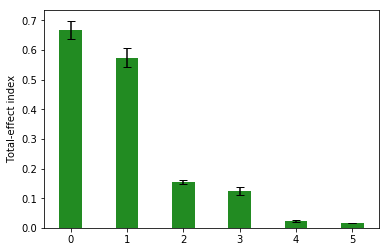

In [9]:
list = Si['ST'][Si['ST'] > 0.01]
index=np.argsort(list)[::-1]

list_cf = Si['ST_conf'][Si['ST'] > 0.01]

plt.bar(range(len(list)),list[index],width=0.4,yerr=list_cf[index],align='center',capsize=4,color='forestgreen')
plt.ylabel("Total-effect index")

plt.show()

In [10]:
print(flabel)
print(list)

['T_oa', 'RH_oa', 'UPS_e', 'T_sa_upper', 'Fan_Pressure_CRAC', 'Chiller_load']
[0.66875629 0.57425825 0.15505725 0.12460754 0.01635555 0.02290153]


In [11]:
label = ['Outdoor air dry bulb\ntemperature','Outdoor air\nrelative humidity','UPS efficiency','Supply air dry bulb\ntemperature set point\n(higher bound)','Chiller load','CRAC fan pressure']

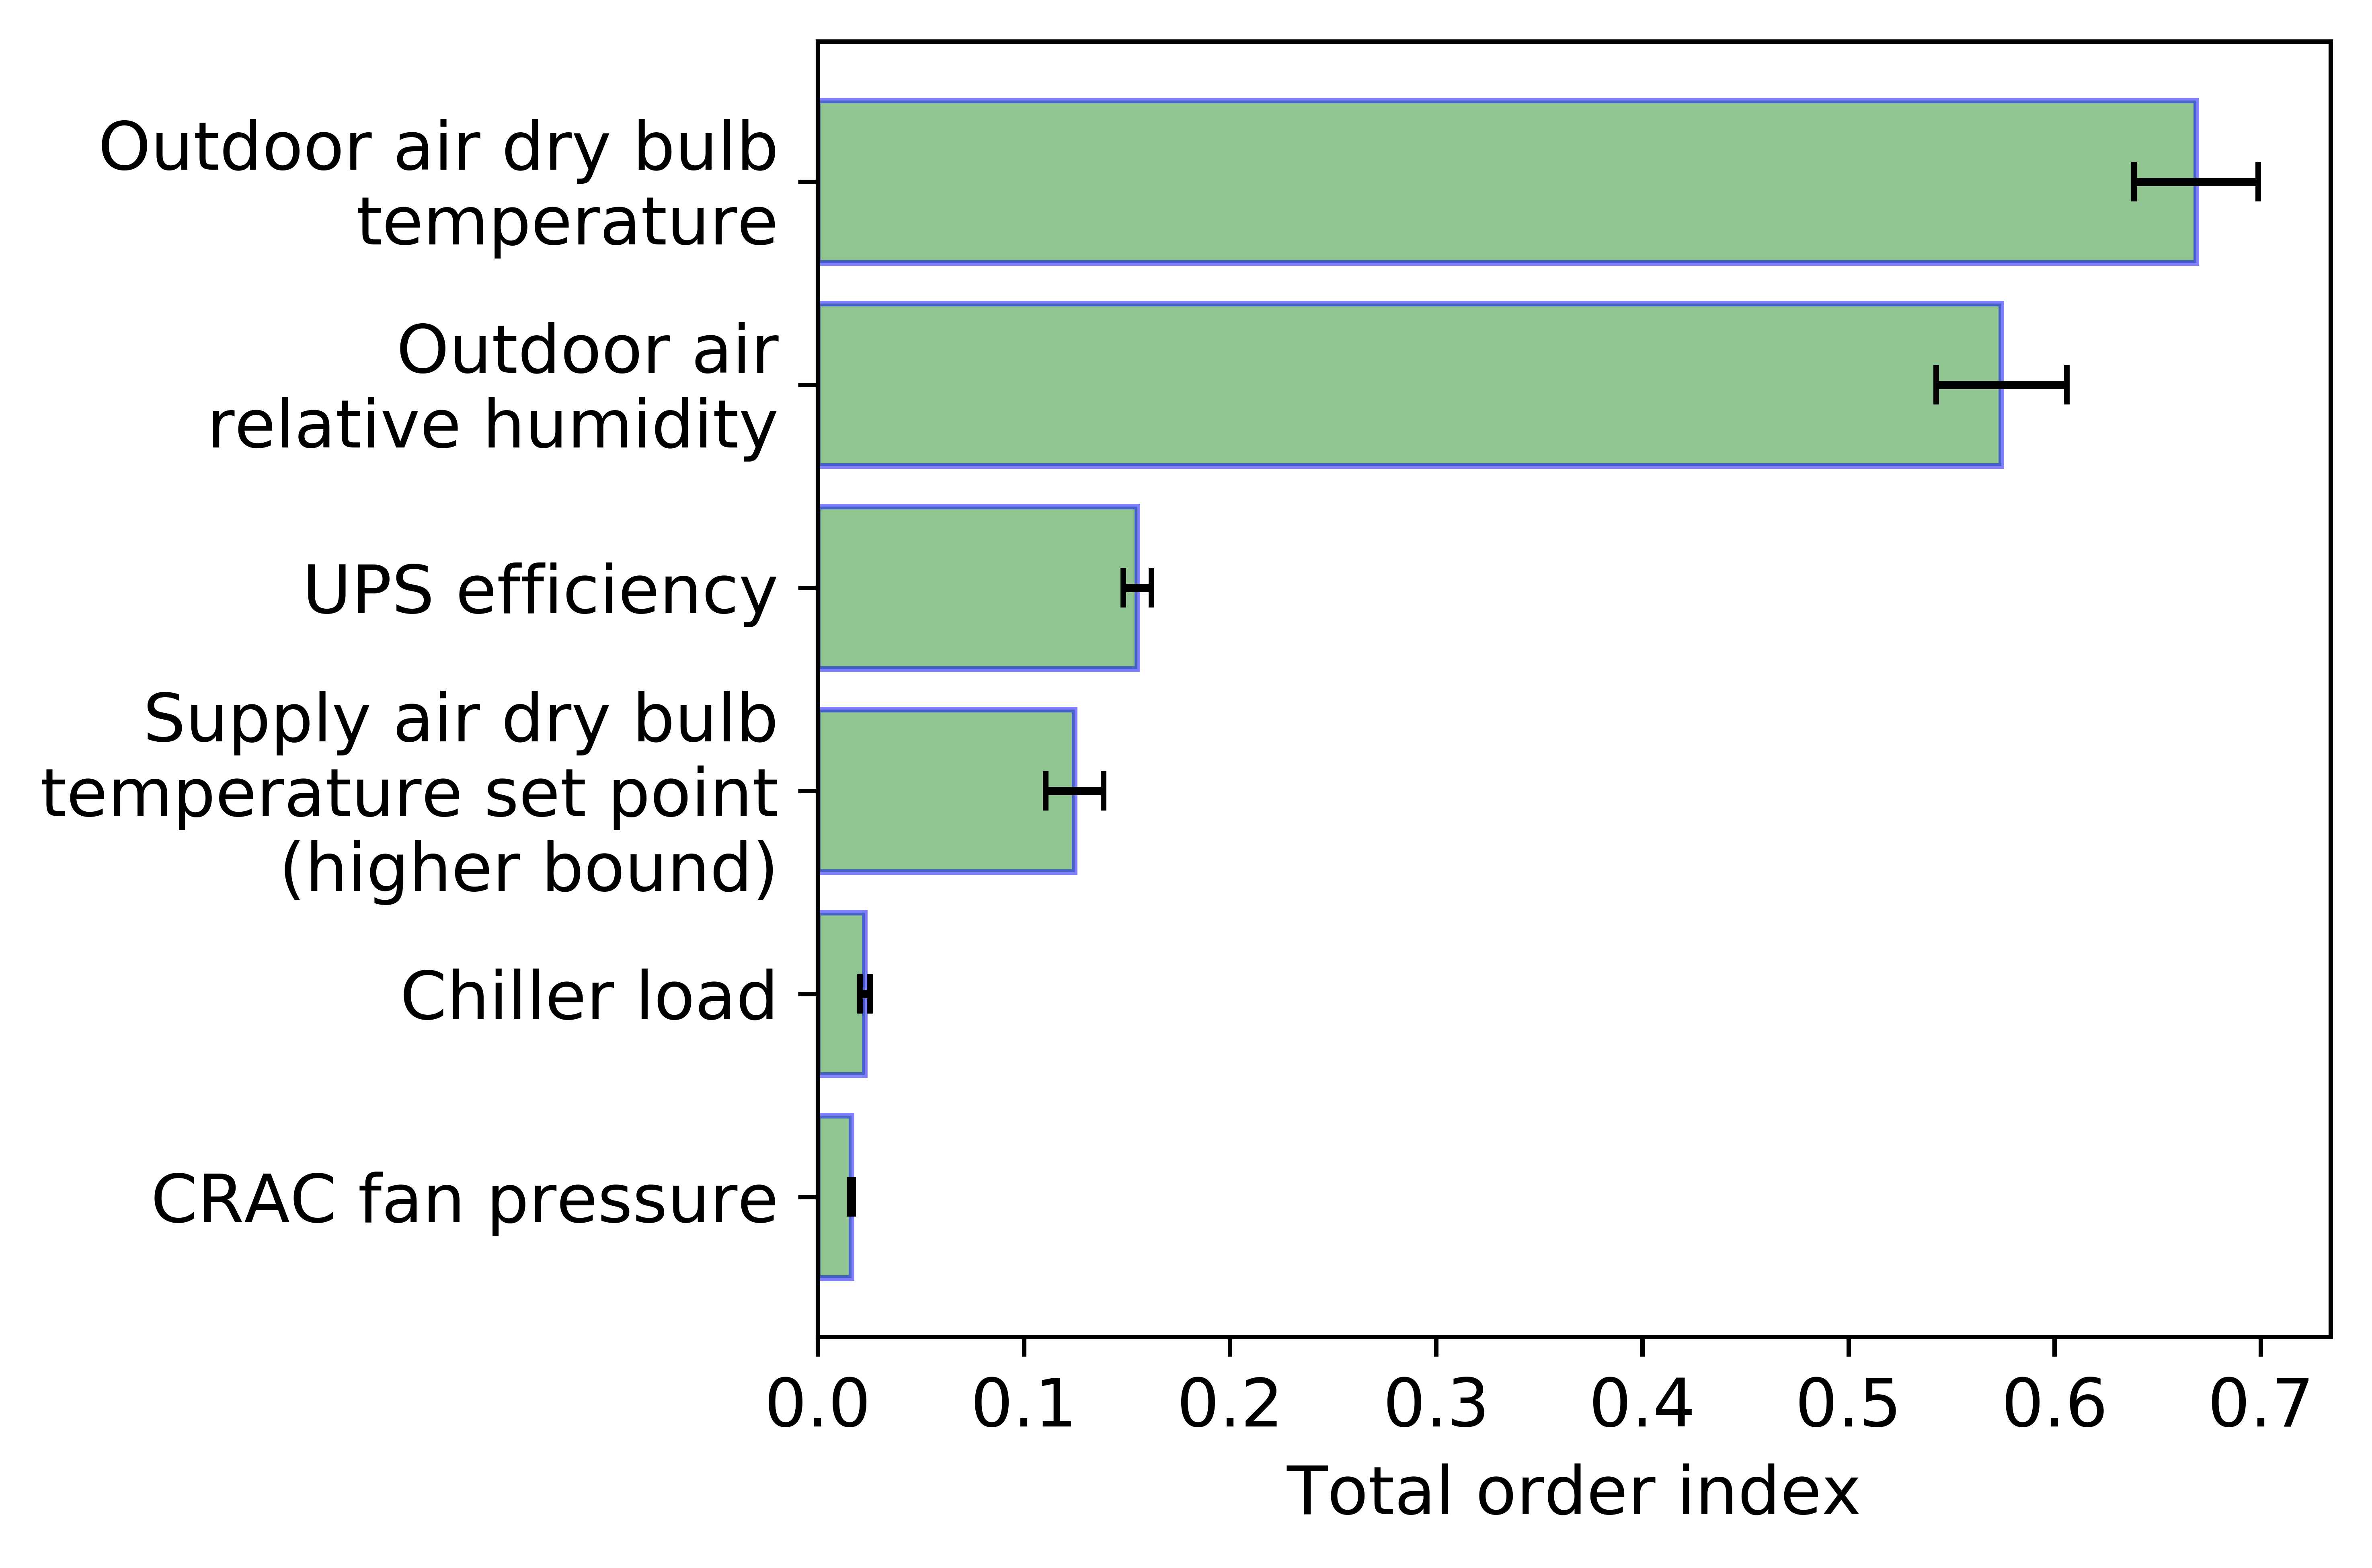

In [12]:
index=np.argsort(list)

plt.figure(dpi=1000)
plt.barh(range(len(list)), list[index], xerr=list_cf[index], align='center',height=0.8,capsize=3.5,color='forestgreen',alpha=0.5,edgecolor='blue')
plt.xlabel("Total order index",fontsize=12)
plt.yticks(range(len(list)),label[::-1], ha='right',fontsize=12)
plt.xticks(fontsize=12)
plt.rc('font',family='Calibri')

plt.tight_layout()
#plt.savefig("AE_sensitity.svg", dpi=1000)
plt.show()

In [13]:
inx = np.argsort(Si['S1'])[::-1]
flabel_2 = []

for i in inx:
    flabel_2.append(problem_AE_Chiller['names'][i])
    
inx_1 = np.argsort(Si['ST'])[::-1]
flabel_1 = []

for i in inx_1:
    flabel_1.append(problem_AE_Chiller['names'][i])

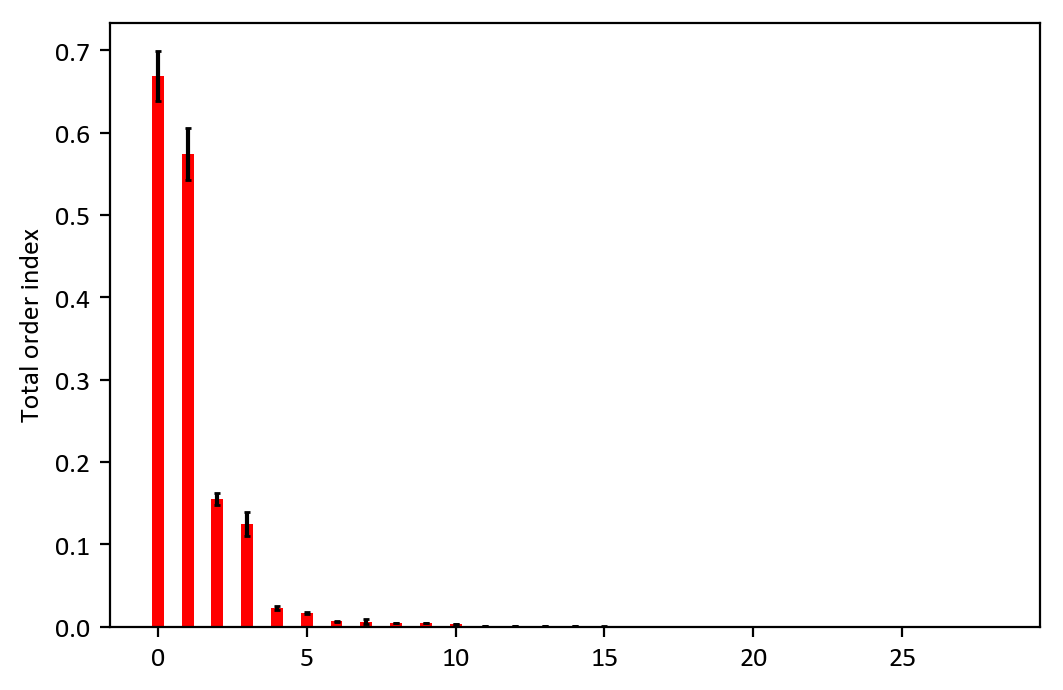

In [14]:
plt.figure(dpi=200)
list_2 = Si['S1'][inx]
list_cf_2 = Si['S1_conf'][inx]

list_1 = Si['ST'][inx_1]
list_cf_1 = Si['ST_conf'][inx_1]

plt.bar(range(len(list_1)),list_1,width=0.4,yerr=list_cf_1,align='center',capsize=1,color='r')

plt.ylabel("Total order index")

plt.show()


In [15]:
print(flabel_1)
print(list_1) 
print(list_cf_1)

print(flabel)
print(list)
print(list_cf)


['T_oa', 'RH_oa', 'UPS_e', 'T_sa_upper', 'Chiller_load', 'Fan_Pressure_CRAC', 'PD_lr', 'P_atm', 'delta_T_air', 'Fan_e_CRAC', 'pCOP', 'AT_CT', 'Fan_Pressure_CT', 'delta_T_CT', 'L_to_G', 'Pump_Pressure_CT', 'L_percentage', 'Pump_e_CT', 'delta_T_water', 'T_sa_lower', 'Fan_e_CT', 'Pump_Pressure_CW', 'Pump_e_CW', 'Pump_e_HD', 'Pump_Pressure_HD', 'RH_sa_lower', 'dp_sa_upper', 'RH_sa_upper', 'dp_sa_lower']
[6.68756285e-01 5.74258246e-01 1.55057245e-01 1.24607539e-01
 2.29015326e-02 1.63555453e-02 6.32386652e-03 6.08181816e-03
 4.36285924e-03 4.02671838e-03 3.25309211e-03 4.32725180e-04
 1.60821585e-04 1.59913201e-04 1.46114378e-04 6.34182763e-05
 6.07250053e-05 3.35818339e-05 3.04326594e-05 2.09034748e-05
 1.36755611e-05 1.03088083e-05 5.29676178e-06 5.14481260e-07
 2.48169467e-07 1.68466242e-32 1.53828809e-32 9.38967888e-33
 0.00000000e+00]
[3.01173238e-02 3.17593438e-02 6.89146439e-03 1.40865840e-02
 2.48252962e-03 7.85006562e-04 2.68201598e-04 2.93510407e-03
 2.29694410e-04 1.87535261e-04 

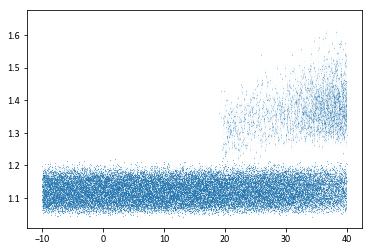

In [16]:
plt.scatter(sobol_values[:,0],Y_sobol,s=0.0001)